In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Import Data

source: http://www.bom.gov.au/climate/data/

In [3]:
df = pd.read_csv("data/daily_min_temp.csv", parse_dates=["Date"], index_col="Date")
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


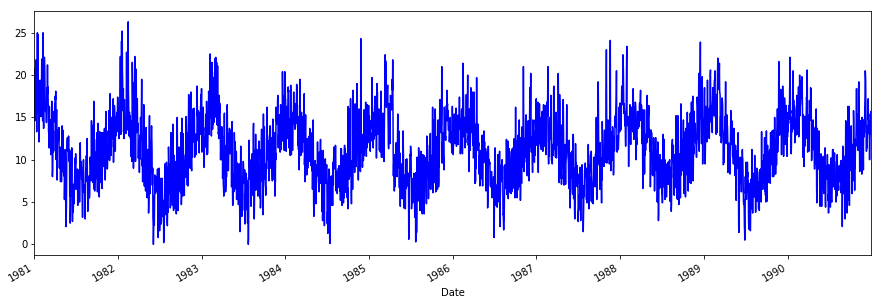

In [4]:
df.Temp.plot(figsize=(15, 5), color='b')

# Dataset Splitting

In [5]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((2920, 1), (730, 1))

# Prepare Sequence

In [6]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

In [7]:
seq_len = 14
bs = 32

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (208, 14, 1)
Note: last 7 data excluded

(N, S, F): (52, 14, 1)
Note: last 1 data excluded



# Arsitektur & Config

In [8]:
from jcopdl.layers import linear_block

In [9]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2*hidden_size, output_size)
        
    def forward(self, x, hidden):        
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

In [10]:
config = set_config({
    "input_size": train_set.n_feature,
    "seq_len": train_set.n_seq,
    "output_size": 1,
    "hidden_size": 64,
    "num_layers": 2,
    "dropout": 0
})

# Training Preparation -> MCOC

In [11]:
model = BiLSTM(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir='model/bilstm')

# Training


Epoch     1
Train_cost  = 132.3817 | Test_cost  = 126.4900 | 

Epoch     2
Train_cost  = 107.6564 | Test_cost  = 95.6694 | 

Epoch     3
Train_cost  = 77.2152 | Test_cost  = 65.5720 | 

Epoch     4
Train_cost  = 51.2185 | Test_cost  = 43.1205 | 

Epoch     5
Train_cost  = 33.7864 | Test_cost  = 29.9491 | 

Epoch     6
Train_cost  = 24.3561 | Test_cost  = 22.9667 | 

Epoch     7
Train_cost  = 19.6914 | Test_cost  = 19.5321 | 

Epoch     8
Train_cost  = 17.6631 | Test_cost  = 18.0130 | 

Epoch     9
Train_cost  = 16.9377 | Test_cost  = 17.4190 | 

Epoch    10
Train_cost  = 16.7500 | Test_cost  = 17.2151 | 

Epoch    11
Train_cost  = 16.7223 | Test_cost  = 17.1508 | 

Epoch    12
Train_cost  = 16.7061 | Test_cost  = 17.1280 | 

Epoch    13
Train_cost  = 16.6724 | Test_cost  = 17.1218 | 

Epoch    14
Train_cost  = 16.6318 | Test_cost  = 17.1234 | 
==> EarlyStop patience =  1 | Best test_cost: 17.1218

Epoch    15
Train_cost  = 16.5941 | Test_cost  = 17.1225 | 
==> EarlyStop patience =  2 

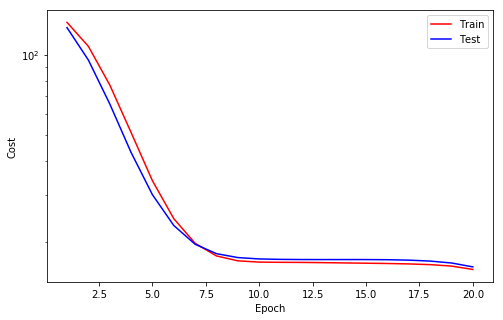


Epoch    21
Train_cost  = 15.0599 | Test_cost  = 15.4097 | 

Epoch    22
Train_cost  = 14.4024 | Test_cost  = 14.7200 | 

Epoch    23
Train_cost  = 13.2662 | Test_cost  = 12.7342 | 

Epoch    24
Train_cost  = 11.2969 | Test_cost  = 10.5876 | 

Epoch    25
Train_cost  = 9.5758 | Test_cost  = 9.1434 | 

Epoch    26
Train_cost  = 8.5706 | Test_cost  = 8.1632 | 

Epoch    27
Train_cost  = 7.8022 | Test_cost  = 7.2893 | 

Epoch    28
Train_cost  = 7.1483 | Test_cost  = 6.6185 | 

Epoch    29
Train_cost  = 6.6137 | Test_cost  = 6.0700 | 

Epoch    30
Train_cost  = 6.1622 | Test_cost  = 5.5956 | 

Epoch    31
Train_cost  = 5.7531 | Test_cost  = 5.1974 | 

Epoch    32
Train_cost  = 5.3677 | Test_cost  = 4.8583 | 

Epoch    33
Train_cost  = 5.0268 | Test_cost  = 4.5453 | 

Epoch    34
Train_cost  = 4.7088 | Test_cost  = 4.2409 | 

Epoch    35
Train_cost  = 4.4052 | Test_cost  = 3.9048 | 

Epoch    36
Train_cost  = 4.1054 | Test_cost  = 3.6231 | 

Epoch    37
Train_cost  = 3.8397 | Test_cost  =

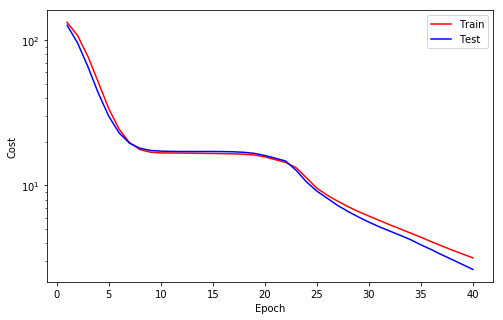


Epoch    41
Train_cost  = 2.9846 | Test_cost  = 2.4441 | 

Epoch    42
Train_cost  = 2.7975 | Test_cost  = 2.2602 | 

Epoch    43
Train_cost  = 2.6246 | Test_cost  = 2.0859 | 

Epoch    44
Train_cost  = 2.4546 | Test_cost  = 1.9233 | 

Epoch    45
Train_cost  = 2.2967 | Test_cost  = 1.7637 | 

Epoch    46
Train_cost  = 2.1416 | Test_cost  = 1.6200 | 

Epoch    47
Train_cost  = 1.9998 | Test_cost  = 1.4890 | 

Epoch    48
Train_cost  = 1.8653 | Test_cost  = 1.3699 | 

Epoch    49
Train_cost  = 1.7409 | Test_cost  = 1.2643 | 

Epoch    50
Train_cost  = 1.6243 | Test_cost  = 1.1617 | 

Epoch    51
Train_cost  = 1.5135 | Test_cost  = 1.0716 | 

Epoch    52
Train_cost  = 1.4145 | Test_cost  = 0.9900 | 

Epoch    53
Train_cost  = 1.3265 | Test_cost  = 0.9221 | 

Epoch    54
Train_cost  = 1.2514 | Test_cost  = 0.8620 | 

Epoch    55
Train_cost  = 1.1849 | Test_cost  = 0.8120 | 

Epoch    56
Train_cost  = 1.1276 | Test_cost  = 0.7621 | 

Epoch    57
Train_cost  = 1.0767 | Test_cost  = 0.7181 

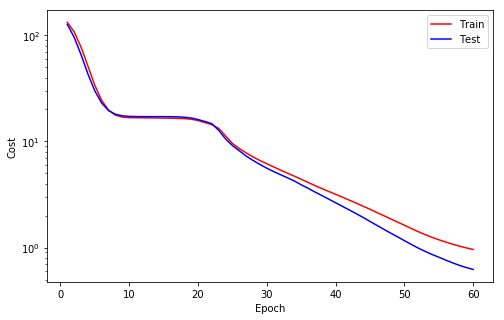


Epoch    61
Train_cost  = 0.9291 | Test_cost  = 0.5974 | 

Epoch    62
Train_cost  = 0.9018 | Test_cost  = 0.5735 | 

Epoch    63
Train_cost  = 0.8761 | Test_cost  = 0.5512 | 

Epoch    64
Train_cost  = 0.8522 | Test_cost  = 0.5316 | 

Epoch    65
Train_cost  = 0.8303 | Test_cost  = 0.5143 | 

Epoch    66
Train_cost  = 0.8103 | Test_cost  = 0.4978 | 

Epoch    67
Train_cost  = 0.7925 | Test_cost  = 0.4793 | 

Epoch    68
Train_cost  = 0.7767 | Test_cost  = 0.4610 | 

Epoch    69
Train_cost  = 0.7595 | Test_cost  = 0.4597 | 

Epoch    70
Train_cost  = 0.7389 | Test_cost  = 0.4490 | 

Epoch    71
Train_cost  = 0.7254 | Test_cost  = 0.4416 | 

Epoch    72
Train_cost  = 0.7149 | Test_cost  = 0.4197 | 

Epoch    73
Train_cost  = 0.6956 | Test_cost  = 0.4061 | 

Epoch    74
Train_cost  = 0.6847 | Test_cost  = 0.4017 | 

Epoch    75
Train_cost  = 0.6798 | Test_cost  = 0.3956 | 

Epoch    76
Train_cost  = 0.6613 | Test_cost  = 0.3928 | 

Epoch    77
Train_cost  = 0.6516 | Test_cost  = 0.3892 

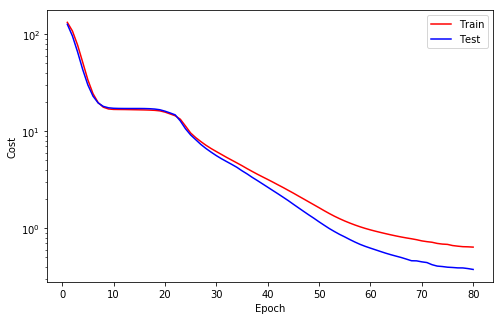


Epoch    81
Train_cost  = 0.6290 | Test_cost  = 0.3593 | 

Epoch    82
Train_cost  = 0.6202 | Test_cost  = 0.3625 | 
==> EarlyStop patience =  1 | Best test_cost: 0.3593

Epoch    83
Train_cost  = 0.6001 | Test_cost  = 0.3520 | 

Epoch    84
Train_cost  = 0.5910 | Test_cost  = 0.3498 | 

Epoch    85
Train_cost  = 0.5909 | Test_cost  = 0.3426 | 

Epoch    86
Train_cost  = 0.5872 | Test_cost  = 0.3441 | 
==> EarlyStop patience =  1 | Best test_cost: 0.3426

Epoch    87
Train_cost  = 0.5695 | Test_cost  = 0.3376 | 

Epoch    88
Train_cost  = 0.5661 | Test_cost  = 0.3385 | 
==> EarlyStop patience =  1 | Best test_cost: 0.3376

Epoch    89
Train_cost  = 0.5545 | Test_cost  = 0.3359 | 

Epoch    90
Train_cost  = 0.5477 | Test_cost  = 0.3342 | 

Epoch    91
Train_cost  = 0.5517 | Test_cost  = 0.3257 | 

Epoch    92
Train_cost  = 0.5565 | Test_cost  = 0.3394 | 
==> EarlyStop patience =  1 | Best test_cost: 0.3257

Epoch    93
Train_cost  = 0.5670 | Test_cost  = 0.3263 | 
==> EarlyStop patienc

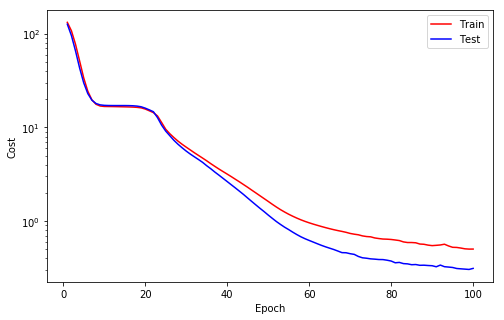

==> EarlyStop patience =  1 | Best test_cost: 0.3050

Epoch   101
Train_cost  = 0.5053 | Test_cost  = 0.3126 | 
==> EarlyStop patience =  2 | Best test_cost: 0.3050

Epoch   102
Train_cost  = 0.5152 | Test_cost  = 0.3054 | 
==> EarlyStop patience =  3 | Best test_cost: 0.3050

Epoch   103
Train_cost  = 0.5449 | Test_cost  = 0.3099 | 
==> EarlyStop patience =  4 | Best test_cost: 0.3050

Epoch   104
Train_cost  = 0.5520 | Test_cost  = 0.3128 | 
==> EarlyStop patience =  5 | Best test_cost: 0.3050
==> Execute Early Stopping at epoch: 104 | Best test_cost: 0.3050
==> Best model is saved at model/bilstm


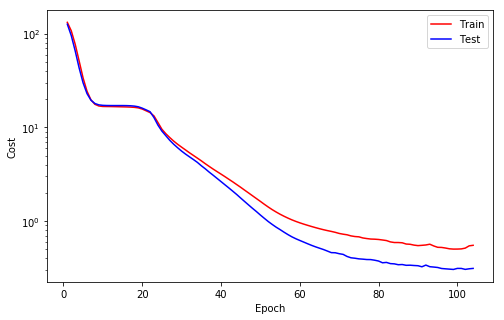

In [12]:
while True:    
    ## Training ##
    model.train()
    cost = 0
    for inputs, targets in trainloader:
        inputs, targets = inputs.to(device), targets.to(device)

        output, hidden = model(inputs, None)
        loss = criterion(output, targets)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        hidden[0].detach_()
        hidden[1].detach_()

        cost += loss.item() * inputs.shape[0]
    train_cost = cost / len(train_set)
    
    ## Testing ##
    with torch.no_grad():
        model.eval()
        cost = 0
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)

            output, hidden = model(inputs, None)
            loss = criterion(output, targets)

            cost += loss.item() * inputs.shape[0]
        test_cost = cost / len(test_set)

    ## Callback ##
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()        
        break

# Load Best Model

In [13]:
weights = torch.load("model/bilstm/weights_best.pth", map_location="cpu")
model.load_state_dict(weights)

<All keys matched successfully>

# Forecast

In [14]:
from luwiji.rnn import illustration

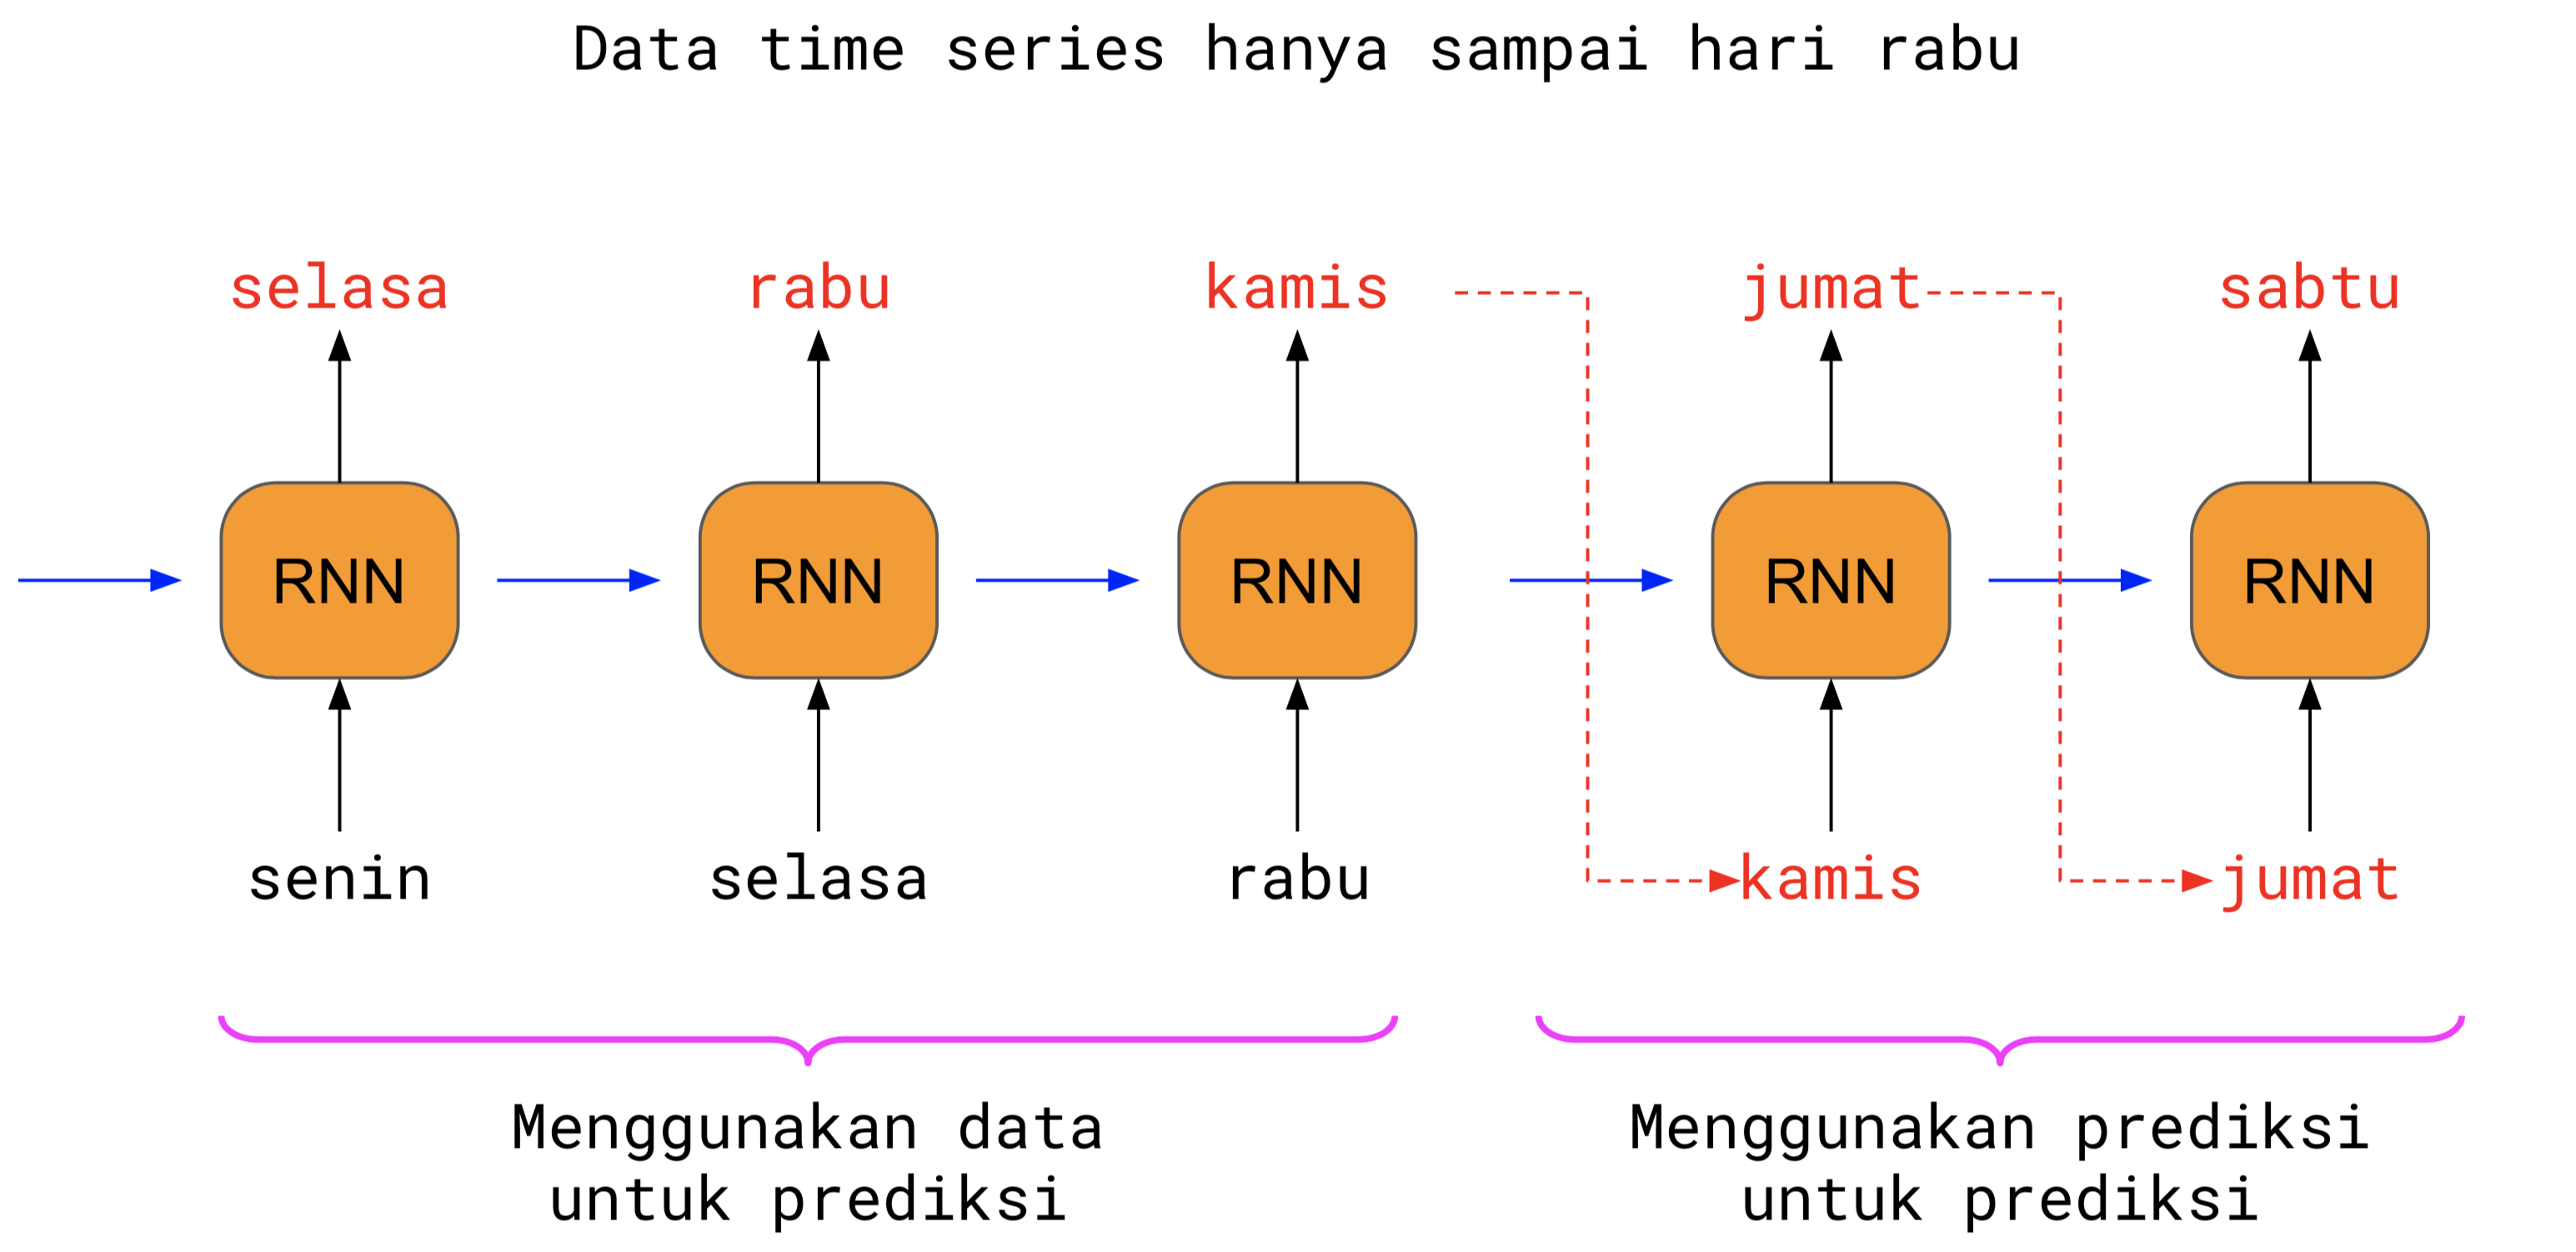

In [15]:
illustration.forecast

In [16]:
from utils import data4pred, pred4pred

In [17]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 1)
Note: last 0 data excluded

(N, S, F): (729, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

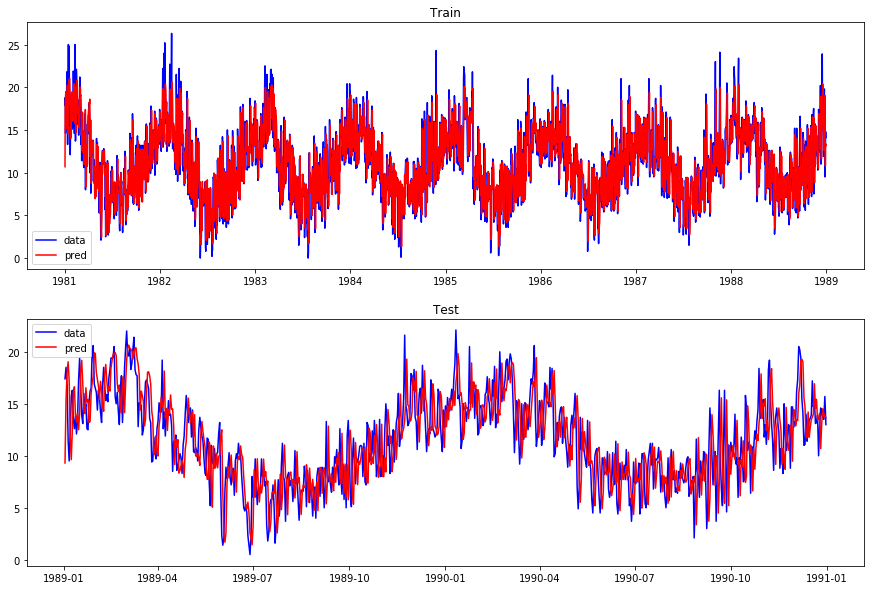

In [18]:
plt.figure(figsize=(15, 10))
    
plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

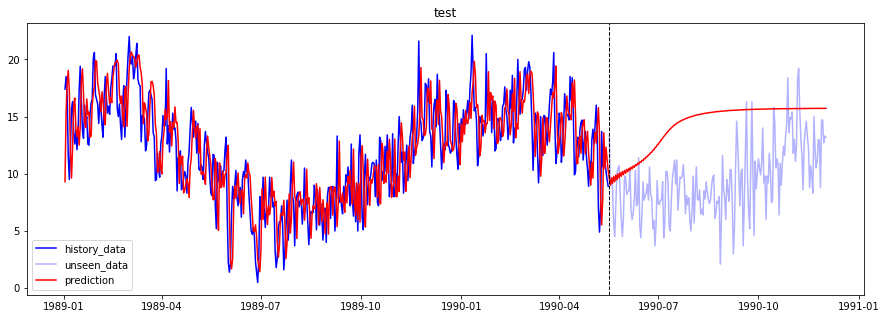

In [19]:
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("test");